In [1]:
import numpy as np
import skimage.io
import skimage.filters
import skimage.morphology
import pandas as pd
import sys

##add the path containing Jwags video analysis files
sys.path.append("behavioral_analysis/")

import segmentation as jwseg 

import motmot.FlyMovieFormat.FlyMovieFormat as FMF

# Opening the flymovie file and creating a background image

In [2]:
#File path the the video file
fname = '/data/2019_03_15_Liometopum_solo\
_test_cam_0_date_2019_03_15_time_\
14_39_32_v001.fmf.3F4BFEBC'

In [3]:
fmf = FMF.FlyMovie(fname)
frame_width = fmf.get_width()
frame_height = fmf.get_height()

In [4]:
frame_num = fmf.get_n_frames()
frame_num

219555

In [5]:
bg_img_set = []
for frame_number in range(100):
    frame,timestamp = fmf.get_frame(frame_number)
    bg_img_set.append(frame)

In [6]:
bg_img = jwseg.construct_bg_img(bg_img_set)

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


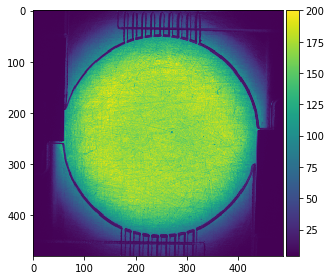

In [7]:
skimage.io.imshow(bg_img)

# Slightly modified functons written by Julian Wagner
Used to perform bg subtraction and meausure the region props of images

In [8]:
def bg_subtract(im1, im2):
    """Function to perform background subtraction on an image
    using a blank image of the arena of interest.
    
    Parameters
    ----------
    im1 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to subtract the
        background from.
    im2 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The background image (with only one color chanel) to subtract the
        from im1.
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m)
        image with background subtracted, i.e. im1-im2.
    """
    im1 = normalize_convert_im(im1)
    im2 = normalize_convert_im(im2)
    
    im_no_bg = im1-im2
    im_no_bg = normalize_convert_im(im_no_bg)
    return (im_no_bg)

In [9]:
def normalize_convert_im(im):
    """Function to normalize an image and convert it to float type.
    Normalized image is between 0. and 1.0.
    
    Parameters
    ----------
    im : numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to get ROI from.
    
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m) of type float 
    and in range of 0. to 1.0.
    """
    
    im = skimage.img_as_float(im)
    im_norm = im - im.min()
    im_norm = im_norm / im_norm.max()
    return im_norm

In [10]:
def segment(im, thresh_func=skimage.filters.threshold_otsu, args=()):
    """Function to threshold an image using skimage functions. 
    The user pases the desired function to determine the threshold
    for the data (or a value to use as the threshold). This value
    for the threshold level can be a float/int or an array of same shape
    as the input image.
    
    Parameters
    ----------
    x : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to threshold.
    thresh_func : function
        The function to use to calculate the thresholding. Should
        return a single scalar value or a numpy array.
    Returns
    -------
    im_bw : 2d numpy.ndarray with shape (n, m)
        Boolean array with location of thresholded objects.
    im_labeled : a labelfield of image
    n_labels : number of identified objects in the labelfield
    """
    thresh = thresh_func(im, *args)
    im_bw = im < thresh
    
    #Remove small objects, i.e. insect legs that are recognized as separate objects
    #from the insect body
    im_bw_big_objs = skimage.morphology.remove_small_objects(im_bw)
    
    # Label binary image; background kwarg says value in im_bw to be background
    im_labeled, n_labels = skimage.measure.label(im_bw_big_objs, background=0, return_num=True)
    
    return im_bw, im_labeled, n_labels

In [11]:
def region_props_to_tuple(rp):
    """Function to extract the region properties from a regionprops
    object.
    
    Parameters
    ----------
    rp : skimage.measure._regionprops._RegionProperties, a region properties
        object from which to extract attributes
    Returns
    -------
    attributes : tuple. The regionproperty fields for many properites of a blob
    labels : tuple. The corresponding label for teh values in attributes
    """     
    labels = ('area', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'bbox_area',
              'centroid_row', 'centroid_col', 'convex_area', 'eccentricity', 'equivalent_diameter',
              'euler_number', 'extent', 'filled_area', 'label', 'local_centroid_row', 'local_centoid_col',
              'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length',
              'orientation', 'perimeter', 'solidity', 'weighted_centroid_row', 'weighted_centroid_col',
              'weighted_local_centoid_row', 'weighted_local_centroid_col')
    
    bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col = rp.bbox
    centroid_row, centroid_col = rp.centroid
    local_centroid_row, local_centoid_col = rp.local_centroid
    weighted_centroid_row, weighted_centroid_col = rp.weighted_centroid
    weighted_local_centoid_row, weighted_local_centroid_col = rp.weighted_local_centroid

    attributes = (rp.area, bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col,
                  rp.bbox_area, centroid_row, centroid_col, rp.convex_area, 
                  rp.eccentricity, rp.equivalent_diameter, rp.euler_number,
                  rp.extent, rp.filled_area, rp.label, local_centroid_row,
                  local_centoid_col, rp.major_axis_length, rp.max_intensity,
                  rp.mean_intensity, rp.min_intensity, rp.minor_axis_length,
                  rp.orientation, rp.perimeter, rp.solidity,
                  weighted_centroid_row, weighted_centroid_col,
                  weighted_local_centoid_row, weighted_local_centroid_col)
    
    return attributes, labels

# Testing the functions above on a test image

In [12]:
#Testing the various functions above
test_frame,_ = fmf.get_frame(2000)
test_nobg = bg_subtract(test_frame, bg_img)
test_thresh,test_label,label_nums = segment(test_nobg)

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


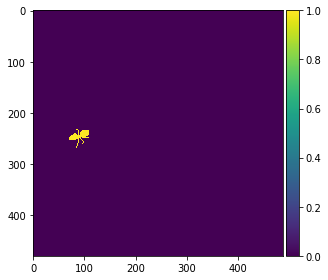

In [13]:
skimage.io.imshow(test_label)

In [14]:
#get region properties of the labeled image
test_rp = skimage.measure.regionprops(test_label,test_nobg)

In [15]:
#convert the region properties to a tuple that can be appended to a dataframe
test_attributes,labels = region_props_to_tuple(test_rp[0])

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [16]:
labels

('area',
 'bbox_min_row',
 'bbox_min_col',
 'bbox_max_row',
 'bbox_max_col',
 'bbox_area',
 'centroid_row',
 'centroid_col',
 'convex_area',
 'eccentricity',
 'equivalent_diameter',
 'euler_number',
 'extent',
 'filled_area',
 'label',
 'local_centroid_row',
 'local_centoid_col',
 'major_axis_length',
 'max_intensity',
 'mean_intensity',
 'min_intensity',
 'minor_axis_length',
 'orientation',
 'perimeter',
 'solidity',
 'weighted_centroid_row',
 'weighted_centroid_col',
 'weighted_local_centoid_row',
 'weighted_local_centroid_col')

# Analyzing first Liometopum baseline video

In [ ]:
#initialize a dataframe to save the data out
df_Lo1 = pd.DataFrame(columns=['timestamp, s',*labels])
print('Frame Number:')

#loop through every frame of the video
for frame_number in range(280,(frame_num-1)):
    
    #grab the frame and timestamp for the given frame
    frame,timestamp = fmf.get_frame(frame_number)
    
    #testing to see if a given frame is a dropped frame
    if frame[0][0] == 0 and \
       frame[int(np.floor(frame_height/2))][int(np.floor(frame_width/2))] == 0 and \
       frame[frame_height-1][frame_width-1] == 0:
        continue
    
    
    frame_nobg = bg_subtract(frame, bg_img)
    frame_thresh,frame_label,label_nums = segment(frame_nobg)
    
    frame_rp = skimage.measure.regionprops(frame_label,frame_nobg)
    
    frame_attributes,_ = region_props_to_tuple(frame_rp[0])
    
    df_hold = pd.DataFrame([[timestamp,*frame_attributes]],columns=['timestamp, s',*labels])
    
    df_Lo1 = df_Lo1.append(df_hold,ignore_index=True)
    
    if frame_number%1000 == 0:
        print(frame_number)

Frame Number:
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000


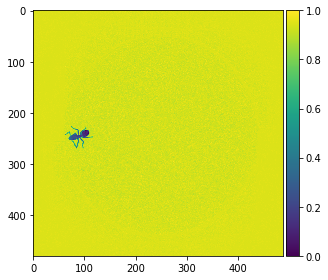

In [18]:
skimage.io.imshow(test_nobg)

In [29]:
frame_number

8544

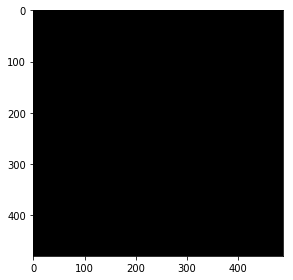

In [31]:
frame,timestamp = fmf.get_frame(frame_number)
skimage.io.imshow(frame)


In [56]:
#looking at the generated data to 
df_Lo1.tail()

,"timestamp, s",area,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,bbox_area,centroid_row,centroid_col,convex_area,...,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid_row,weighted_centroid_col,weighted_local_centoid_row,weighted_local_centroid_col
143587,1713.303941,500,396,171,425,213,1218,411.628000,191.708000,833,...,0.202184,0.0,18.684946,0.388105,170.740115,0.600240,412.491483,189.697847,16.491483,18.697847
143588,1713.315846,491,393,171,425,216,1440,411.773931,191.610998,883,...,0.196040,0.0,19.284771,0.368921,183.468037,0.556059,412.781971,189.585744,19.781971,18.585744
143589,1713.327751,501,393,171,425,216,1440,411.580838,191.782435,981,...,0.201425,0.0,19.837896,0.406490,194.296465,0.510703,412.314974,190.118446,19.314974,19.118446
143590,1713.339656,486,393,171,425,216,1440,411.973251,191.335391,866,...,0.191460,0.0,19.069794,0.358782,177.846717,0.561201,413.047977,189.260721,20.047977,18.260721
143591,1713.351561,505,393,171,425,216,1440,411.952475,191.219802,922,...,0.197756,0.0,19.659857,0.363199,190.710678,0.547722,412.925221,189.213330,19.925221,18.213330


In [57]:
#saving out the data
df_Lo1.to_csv('~/sceptovideo/2019_03_15_Liometopum_solo_trial_01.csv')